In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score, make_scorer
import matplotlib.pyplot as plt

In [2]:
cc_data = pd.read_csv('cleaned_confirmed_cases.csv')
cc_data = pd.concat([cc_data,pd.get_dummies(cc_data['Country_Region'], prefix='country')],axis=1)
diff_split_cc_data = cc_data.copy()
# dropping first infection along with country and date
cc_data.drop(['Country_Region', 'Date', 'first_infection'],axis=1, inplace=True)
feature_cols = list(cc_data)
feature_cols.remove('TargetValue')
mask_test = (diff_split_cc_data['Date'] >= '2020-05-20')
mask_train = (diff_split_cc_data['Date'] < '2020-05-20')

In [3]:
test_cc_df = diff_split_cc_data.loc[mask_test]
train_cc_df = diff_split_cc_data.loc[mask_train]
y_time_split_cc = train_cc_df['TargetValue']
x_time_split_cc = train_cc_df[feature_cols] 

y_test_time_split_cc = test_cc_df['TargetValue']
x_test_time_split_cc = test_cc_df[feature_cols]

In [4]:
gradient_boosting_regr = GradientBoostingRegressor()
gradient_boosting_regr.fit(x_time_split_cc,y_time_split_cc)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
y_pred_cc = gradient_boosting_regr.predict(x_test_time_split_cc)
print(gradient_boosting_regr.score(x_test_time_split_cc, y_test_time_split_cc))

0.797985163700536


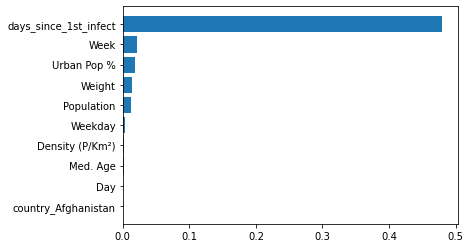

In [21]:
feature_imp = gradient_boosting_regr.feature_importances_[:10]
sorted_idx = np.argsort(feature_imp)
pos = np.arange(sorted_idx.shape[0])+.5

plt.barh(pos, feature_imp[sorted_idx], align='center')
plt.yticks(pos, np.array(list(x_time_split_cc))[sorted_idx])
plt.show()

## Optimizing hyperparams

In [6]:
from sklearn.model_selection import RandomizedSearchCV

In [7]:
params = {'loss':['ls', 'lad'],
             'learning_rate': list(np.logspace(np.log10(0.09), np.log10(0.25), base = 10, num = 600)),
             'max_depth': list(range(1, 6)),
             'min_samples_leaf':list(range(1,4)),
          'n_estimators':list(range(70,120)),
          'criterion':['friedman_mse', 'mse', 'mae']
              }

In [ ]:
rand_search = RandomizedSearchCV(gradient_boosting_regr, params, scoring= 'r2', n_iter = 150)
search = rand_search.fit(x_time_split_cc,y_time_split_cc)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
best_params= search.best_params_
optGBR = GradientBoostingRegressor(loss=best_params['loss'], learning_rate= best_params['learning_rate'], min_samples_leaf=best_params['min_samples_leaf'],
                      max_depth=best_params['max_depth'], criterion = best_params['criterion'])
optGBR.fit(x_time_split_cc,y_time_split_cc)
y_pred_cc = optGBR.predict(x_test_time_split_cc)
print(optGBR.score(x_test_time_split_cc, y_test_time_split_cc))

In [118]:
best_params

{'n_estimators': 82,
 'min_samples_leaf': 1,
 'max_depth': 3,
 'loss': 'ls',
 'learning_rate': 0.11204454789028422}

In [105]:
search.cv_results_

{'mean_fit_time': array([1.14360825, 1.62598705, 2.49107472, 1.79021207, 1.40258257,
        2.60702848, 1.78855077, 3.75761954, 5.29085271, 1.42951075,
        2.20944381, 1.94845621, 1.93183462, 1.29121455, 2.76726635,
        3.34372679, 0.28955921, 1.04919481, 0.77260017, 2.59606043,
        2.43515563, 0.73636476, 2.56016564, 4.43655292, 1.17785048,
        0.65857283, 0.36037024, 2.05683382, 0.880313  , 0.74867574,
        3.23102641, 0.95477962, 0.82113735, 2.51728058, 1.10504429,
        4.79850396, 2.85969949, 1.38297002, 1.11368918, 1.03323698,
        3.471071  , 3.29823526, 1.36351426, 2.02265755, 0.55393171,
        0.65382099, 3.69373639, 0.63116225, 0.69377176, 0.82158422]),
 'std_fit_time': array([0.03663631, 0.01864521, 0.00941835, 0.04336408, 0.01323864,
        0.05337985, 0.03197086, 0.53801038, 0.11823309, 0.01262306,
        0.09746211, 0.02246952, 0.03463572, 0.016715  , 0.02932987,
        0.03128808, 0.00542355, 0.01310355, 0.00329222, 0.0080195 ,
        0.011